In [154]:
import os
import numpy as np
import pandas as pd
import cv2 # OpenCV
from alive_progress import alive_bar
import time
from pathlib import Path
from sklearn.svm import SVC # SVM klasifikator
from skimage.feature import hog as HOG
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier # KNN
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [155]:
mask_on_classifier = pickle.load(open('mask_on_classifier.sav', 'rb'))
mask_off_classifier = pickle.load(open('mask_off_classifier.sav', 'rb'))
mask_classifier = pickle.load(open('mask_classifier.sav', 'rb'))

default_window_size = 40

img_base_path = str(Path().absolute()) + "\\archive\\images\\"

In [156]:
# define parameters of HOG feature extraction
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
threshold = .3

def classify_window(window, svm_classifier):
    features = HOG(window, orientations, pixels_per_cell, cells_per_block, block_norm='L2', feature_vector=True).reshape(1, -1)
    result = svm_classifier.predict_proba(features);
    return result[0][1]

In [157]:
def process_image(image, step_size, window_size=(40, 40), both_threshold=0.9, single_thresh=0.95):
    
    windows = []
    
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            this_window = (y, x) # zbog formata rezultata
            window = image[y:y+window_size[1], x:x+window_size[0]]
            if window.shape == (window_size[1], window_size[0]):
                score_mask_on = classify_window(window, mask_on_classifier)
                score_mask_off = classify_window(window, mask_off_classifier)
                
                #plt.figure()
                #plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
                #plt.title(str(x) + ' , ' + str(y) + ' - ' + str(score_mask_on))
                
                if score_mask_off > both_threshold and score_mask_on > both_threshold:
                    if score_mask_off > single_thresh or score_mask_on > single_thresh:
                        window_images.append(window)
                        windows.append(this_window)
                    
    return windows

In [158]:
def jaccard_index(true_box, predicted_box):
    y_a = max(true_box[0], predicted_box[0])
    x_a = max(true_box[1], predicted_box[1])
    y_b = min(true_box[2], predicted_box[2])
    x_b = min(true_box[3], predicted_box[3])
    
    inter_area = max(0, x_b - x_a + 1) * max(0, y_b - y_a + 1)
    
    true_area = (true_box[3] - true_box[1] + 1) * (true_box[2] - true_box[0] + 1)

    pred_area = (predicted_box[3] - predicted_box[1] + 1) * (predicted_box[2] - predicted_box[0] + 1)
    
    iou = inter_area / float(true_area + pred_area - inter_area)
    
    return max(iou, 0)

In [183]:
def NMS(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    # initialize the list of picked indexes
    pick = []
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + 40
    y2 = boxes[:,1] + 40
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

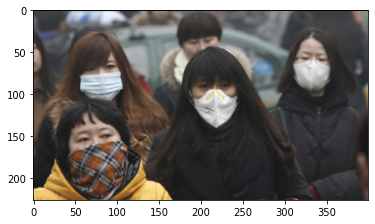

In [184]:
image = cv2.imread(img_base_path + "maksssksksss21.png")
#image = cv2.pyrDown(image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


window_images = []


image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

windows = process_image(image, step_size=4)
windows_grouped = np.array(windows)
windows_grouped = np.c_[ windows_grouped, np.full((len(windows_grouped), 1), default_window_size) ]
windows_grouped = NMS(windows_grouped)

image = cv2.pyrDown(image)

i = 2

while image.shape[0] >= default_window_size and image.shape[1] >= default_window_size:
    
    windows = process_image(image, step_size=4)
    
    if len(windows) != 0:
        windows = np.c_[ windows, np.full((len(windows), 1), i*default_window_size) ]
        windows = NMS(windows)
        windows_grouped = np.vstack((windows_grouped, windows))
    
    image = cv2.pyrDown(image)
    i += 1


[[ 56 316  40]
 [100 200  40]
 [140  68  40]
 [180  40  40]
 [ 20   4  40]
 [ 32  88  80]
 [ 72  24  80]
 [ 20  20  80]]
[0, 4, 5, 6, 7]


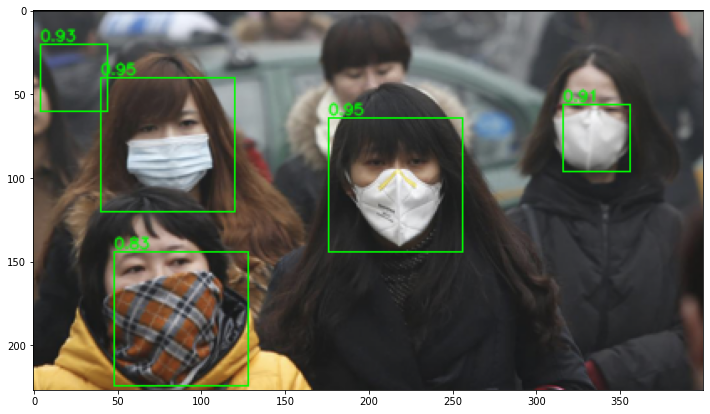

In [186]:
base_image = cv2.imread(img_base_path + "maksssksksss21.png")

#windows_grouped_nms = NMS(windows_grouped)    
windows_grouped_nms = windows_grouped

#windows_grouped_nms = windows_grouped_nms[windows_grouped_nms[:, 2].argsort()]

print(windows_grouped_nms)

indx = []

for i in range(len(windows_grouped_nms)):
    indx.append(i)


for (x1,y1,d1) in windows_grouped_nms:
    
    scale1 = d1/default_window_size
    i = -1
    
    for (x2,y2,d2) in windows_grouped_nms:
        i += 1
        
        if d1 == d2:
            continue
        
        if x1 == x2 and y1 == y2:
            continue
            
        if x2+d2/2 >= x1*scale1 and x2+d2/2 <= x1*scale1+d1 and y2+d2/2 >= y1*scale1 and y2+d2/2 <= y1*scale1+d1:
            try:
                indx.remove(i)
            except:
                pass


windows_grouped_nms = windows_grouped_nms[indx]
        
print(indx)

i = 1

img = cv2.cvtColor(base_image, cv2.COLOR_BGR2GRAY)

for (x,y,d) in windows_grouped_nms:
    
    while d != i*default_window_size:
        img = cv2.pyrDown(img)
        i += 1
        
    score_mask = classify_window(img[x:x+default_window_size, y:y+default_window_size], mask_classifier)

    if score_mask > 0.7:
        image = cv2.rectangle(base_image,(y*i,x*i),(y*i+d,x*i+d),(0,250,0),1)
        image = cv2.putText(base_image, str(score_mask)[0:4], (y*i,x*i-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 250, 0), 1, cv2.LINE_AA)
    else:
        image = cv2.rectangle(base_image,(y*i,x*i),(y*i+d,x*i+d),(0,0,250),1)
        image = cv2.putText(base_image, str(score_mask)[0:4], (y*i,x*i-2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 250), 1, cv2.LINE_AA)
        
    img = base_image
    i = 1

    
plt.figure(figsize=(12,12))
plt.imshow(cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB))